In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

from fastai.text import *
from fastai import *

In [2]:
from pathlib import Path

In [3]:
torch.cuda.set_device(0)

In [4]:
DATA_PATH = Path('data/comments/')
TEST_CSV = DATA_PATH/'test.csv'
TRAIN_CSV = DATA_PATH/'train.csv'
TEST_LABELS_CSV = DATA_PATH/'test_labels.csv'

## Loading Data

In [5]:
chunksize = 24000

In [6]:
CLAS_PATH=Path('data/comment_clas/')
CLAS_PATH.mkdir(exist_ok=True)

LM_PATH=Path('data/comment_lm/')
LM_PATH.mkdir(exist_ok=True)

In [7]:
test = pd.read_csv(TEST_CSV)
test_labels = pd.read_csv(TEST_LABELS_CSV)
train = pd.read_csv(TRAIN_CSV, chunksize=chunksize, header='infer')

In [8]:
test_combined = pd.merge(
    test, test_labels
)

In [9]:
test_combined.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,00001cee341fdb12,Yo bitch Ja Rule is more succesful then you'll...,-1,-1,-1,-1,-1,-1
1,0000247867823ef7,== From RfC == \n\n The title is fine as it is...,-1,-1,-1,-1,-1,-1
2,00013b17ad220c46,""" \n\n == Sources == \n\n * Zawe Ashton on Lap...",-1,-1,-1,-1,-1,-1
3,00017563c3f7919a,":If you have a look back at the source, the in...",-1,-1,-1,-1,-1,-1
4,00017695ad8997eb,I don't anonymously edit articles at all.,-1,-1,-1,-1,-1,-1


In [10]:
# input - df: a Dataframe, chunkSize: the chunk size
# output - a list of DataFrame
# purpose - splits the DataFrame into smaller of max size chunkSize (last is smaller)
def split_to_chunks(df, chunkSize): 
    listOfDf = list()
    numberChunks = len(df) // chunkSize + 1
    for i in range(numberChunks):
        listOfDf.append(df[i*chunkSize:(i+1)*chunkSize])
    return listOfDf

In [11]:
test_combined = split_to_chunks(test_combined, chunksize)

In [12]:
list_classes = ["toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"]

## Configuring Training Data

In [13]:
rel = re.compile(r'  +')
def fixup(x: str):
    x = x.replace('#39;', "'").replace('amp;', '&').replace('#146;', "'").replace(
        'nbsp;', ' ').replace('#36;', '$').replace('\\n', "\n").replace('quot;', "'").replace(
        '<br />', "\n").replace('\\"', '"').replace('<unk>','u_n').replace(' @.@ ','.').replace(
        ' @-@ ','-').replace('\\', ' \\ ')
    return rel.sub(' ', x)

In [14]:
BOS = 'xbos'
FLD = 'xfld'

In [15]:
def get_texts(row):
    labels = row[list_classes].values
    texts = f'\n{BOS} {FLD} 1 ' + row['comment_text'].astype(str)
    texts = texts.apply(fixup).values.astype(str)
    tok = Tokenizer().proc_all_mp(partition_by_cores(texts))
    return list(tok), list(labels)

In [16]:
def tokenize_texts(df):
    full_text = []
    labels = []
    print(f"TOKENIZING comments")
    total = 0
    for i, row in enumerate(df):
        print(total)
        tok_, labels_ = get_texts(row)
        full_text += tok_
        labels += labels_
        total += chunksize
    print("DONE_TOKENIZING")
    return full_text, labels

In [17]:
full_text, labels = tokenize_texts(df=train)

TOKENIZING comments
0
24000
48000
72000
96000
120000
144000
DONE_TOKENIZING


In [18]:
test_text, test_labels = tokenize_texts(df=test_combined)

TOKENIZING comments
0
24000
48000
72000
96000
120000
144000
DONE_TOKENIZING


In [19]:
def unison_shuffled_copies(a, b):
    assert len(a) == len(b)
    p = np.random.permutation(len(a))
    return a[p], b[p]

In [20]:
full_text = np.array(full_text)
labels = np.array(labels)

In [21]:
full_text, labels = unison_shuffled_copies(full_text, labels)

In [22]:
train_ratio = .9
num_train = int(len(full_text) * train_ratio)
train_text = full_text[:num_train]
train_label = labels[:num_train]

val_text = full_text[num_train:]
val_label = labels[num_train:]

In [23]:
freq = Counter(p for o in full_text for p in o)

In [24]:
freq.most_common(25)

[('.', 518563),
 ('the', 496093),
 (',', 470070),
 ('"', 379000),
 ('to', 297298),
 ('\n', 245545),
 ('i', 239089),
 ('of', 224411),
 ('and', 223817),
 ('you', 217497),
 ('a', 214903),
 ('t_up', 207139),
 ('is', 180721),
 ('1', 164517),
 ('that', 161499),
 ('xbos', 159571),
 ('xfld', 159571),
 ('it', 148152),
 ('in', 144913),
 ('\n\n', 115219),
 ('for', 102644),
 ('this', 97187),
 ('not', 96865),
 ('on', 89843),
 ('-', 88567)]

In [25]:
max_vocab = 60000
min_freq = 2

In [26]:
int_to_string = [o for o, c in freq.most_common(max_vocab) if c > min_freq]
int_to_string.insert(0, '_pad_')
int_to_string.insert(0, '_unk_')

In [27]:
string_to_int = collections.defaultdict(
    lambda: 0,
    {v: k for k, v in enumerate(int_to_string) }
)

In [28]:
train_ratio = .9
num_train = int(len(full_text) * train_ratio)

train_text = full_text[:num_train]
train_label = labels[:num_train]

val_text = full_text[num_train:]
val_label = labels[num_train:]

## Loading WikiText103

In [29]:
# ! wget -nH -r -np -P {DATA_PATH} http://files.fast.ai/models/wt103/

In [30]:
PRE_PATH = Path('data/models/wt103')
PRE_LM_PATH = PRE_PATH/'fwd_wt103.h5'

In [31]:
embedding_size = 400
n_hidden = 1150
n_layers = 3

In [32]:
wgts = torch.load(
    PRE_LM_PATH, map_location = lambda storage, loc: storage
)

encoder_wgts = to_np(wgts['0.encoder.weight'])
row_m = encoder_wgts.mean(axis=0)

In [33]:
itos_wikitext = pickle.load((PRE_PATH/'itos_wt103.pkl').open('rb'))
stoi_wikitext = collections.defaultdict(
    lambda: -1,
    {v: k for k, v in enumerate(itos_wikitext)},
)

In [34]:
vs = len(int_to_string)

In [35]:
new_wgts = np.zeros((vs, embedding_size), dtype=np.float32)
for i, w in enumerate(int_to_string):
    r = stoi_wikitext[w]
    new_wgts = encoder_wgts[r] if r >= 0 else row_m

In [36]:
wgts['0.encoder.weight'] = T(new_wgts)
wgts['0.encoder_with_dropout.embed.weight'] = T(np.copy(new_wgts))
wgts['1.decoder.weight'] = T(np.copy(new_wgts))

## Language Model

In [37]:
def pretty_size(size):
    """Pretty prints a torch.Size object"""
    assert(isinstance(size, torch.Size))
    return " × ".join(map(str, size))

def dump_tensors(gpu_only=True):
    """Prints a list of the Tensors being tracked by the garbage collector."""
    import gc
    total_size = 0
    for obj in gc.get_objects():
        try:
            if torch.is_tensor(obj):
                if not gpu_only or obj.is_cuda:
                    print("%s:%s%s %s" % (type(obj).__name__, 
                                          " GPU" if obj.is_cuda else "",
                                          " pinned" if obj.is_pinned else "",
                                          pretty_size(obj.size())))
                    total_size += obj.numel()
            elif hasattr(obj, "data") and torch.is_tensor(obj.data):
                if not gpu_only or obj.is_cuda:
                    print("%s → %s:%s%s%s%s %s" % (type(obj).__name__, 
                                                   type(obj.data).__name__, 
                                                   " GPU" if obj.is_cuda else "",
                                                   " pinned" if obj.data.is_pinned else "",
                                                   " grad" if obj.requires_grad else "", 
                                                   " volatile" if obj.volatile else "",
                                                   pretty_size(obj.data.size())))
                    total_size += obj.data.numel()
        except Exception as e:
            pass        
    print("Total size:", total_size)

In [38]:
dump_tensors()

FloatTensor: GPU pinned 400
FloatTensor: GPU pinned 400
FloatTensor: GPU pinned 400


/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:19: FutureWarning: RangeIndex.data is deprecated and will be removed in a future version
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:19: FutureWarning: Index.data is deprecated and will be removed in a future version
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:19: FutureWarning: Series.data is deprecated and will be removed in a future version
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:19: FutureWarning: Int64Index.data is deprecated and will be removed in a future version


Total size: 1200


In [39]:
wd = 1e-7
bptt = 70
bs = 32
opt_fn = partial(optim.Adam, betas=(.8, .99))

In [40]:
train_lm = np.array([[string_to_int[o] for o in p] for p in train_text])
val_lm = np.array([[string_to_int[o] for o in p] for p in val_text])

In [41]:
trn_dl = LanguageModelLoader(np.concatenate(train_lm), bs, bptt)
val_dl = LanguageModelLoader(np.concatenate(val_lm), bs, bptt)


md = LanguageModelData(
    DATA_PATH, 1, vs, trn_dl, val_dl, bs=bs, bptt=bptt
)

In [42]:
drops = np.array([0.25, 0.1, 0.2, 0.02, 0.15])*0.7

In [43]:
learner= md.get_model(
    opt_fn, embedding_size, n_hidden, n_layers, 
    dropouti=drops[0], dropout=drops[1], wdrop=drops[2],
    dropoute=drops[3], dropouth=drops[4]
)

learner.metrics = [accuracy]
learner.freeze_to(-1)

In [44]:
learner.model.load_state_dict(wgts)
learner.freeze_to(-1)

In [45]:
# learner.lr_find()
# learner.sched.plot()
# Above code suggested 1e-4

In [46]:
lr = 1e-4
lrs = lr

In [47]:
learner.fit(lr/2, 1, wds=wd, use_clr=(32, 2), cycle_len=1)

epoch      trn_loss   val_loss   accuracy                     
    0      6.217466   6.184234   0.115963  



[array([6.18423]), 0.11596316804496407]

In [48]:
learner.unfreeze()

In [49]:
learner.fit(lrs, 1, wds=wd, use_clr=(20, 10), cycle_len=2)

epoch      trn_loss   val_loss   accuracy                     
    0      4.988557   4.998474   0.235882  
    1      4.860359   4.863217   0.25208                      



[array([4.86322]), 0.25208048669419847]

In [50]:
learner.save('lm2')

In [51]:
learner.save_encoder('lm2_enc')

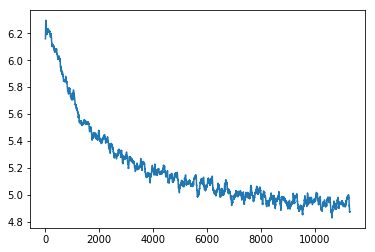

In [52]:
learner.sched.plot_loss()

In [54]:
learner.fit(
    lrs,
    1,
    wds=wd, use_clr=(20, 10),
    cycle_len=4,
    best_save_name='lm3'
)

epoch      trn_loss   val_loss   accuracy                     
    0      4.735466   4.682536   0.271762  
    1      4.571936   4.564166   0.284377                     
    2      4.510866   4.504071   0.290617                     
    3      4.503865   4.481831   0.293605                     


[array([4.48183]), 0.2936048714417194]

In [55]:
learner.load('lm3')

In [56]:
learner.save_encoder('lm3_enc')

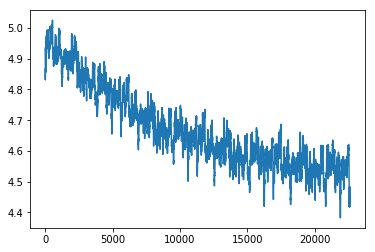

In [57]:
learner.sched.plot_loss()

## Classifier Model

In [58]:
wd = 1e-7
bptt = 70
bs = 32
opt_fn = partial(optim.Adam, betas=(.8, .99))

In [59]:
trn_labels = np.matrix(train_label)
val_labels = np.matrix(val_label)
test_labels = np.matrix(test_labels)

In [60]:
val_label

array([[0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       ...,
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0]])

In [61]:
c = len(list_classes)
min_lbl = trn_labels.min()

In [62]:
min_lbl

0

In [63]:
trn_clas = np.array([[string_to_int[o] for o in p] for p in train_text])
val_clas = np.array([[string_to_int[o] for o in p] for p in val_text])
test_clas = np.array([[string_to_int[o] for o in p] for p in test_text])

In [64]:
len(trn_clas), len(trn_labels), len(val_clas), len(val_labels), len(test_clas), len(test_labels)

(143613, 143613, 15958, 15958, 153164, 153164)

In [65]:
trn_ds = TextDataset(trn_clas, trn_labels.astype('float'))
val_ds = TextDataset(val_clas, val_labels.astype('float'))
test_ds = TextDataset(test_clas, test_labels.astype('float'))

trn_samp = SortishSampler(trn_clas, key=lambda x: len(trn_clas[x]), bs=bs//2)
val_samp = SortSampler(val_clas, key=lambda x: len(val_clas[x]))

trn_dl = DataLoader(trn_ds, bs//4, transpose=True, num_workers=1, pad_idx=1, sampler=trn_samp)
val_dl = DataLoader(val_ds, bs, transpose=True, num_workers=1, pad_idx=1, sampler=val_samp)
test_dl = DataLoader(test_ds, bs, transpose=True, num_workers=1, pad_idx=1)

md = ModelData(DATA_PATH, trn_dl, val_dl, test_dl)

In [66]:
dps = np.array([0.4,0.5,0.05,0.3,0.4])*.3

In [67]:
m = get_rnn_classifer(bptt, 20*70, c, vs, emb_sz=embedding_size, n_hid=n_hidden, n_layers=n_layers, pad_token=1,
          layers=[embedding_size*3, 50, c], drops=[dps[4], 0.1],
          dropouti=dps[0], wdrop=dps[1], dropoute=dps[2], dropouth=dps[3])

In [68]:
learn = RNN_Learner(md, TextModel(to_gpu(m)), opt_fn=opt_fn)
learn.reg_fn = partial(seq2seq_reg, alpha=2, beta=1)

In [69]:
from sklearn.metrics import log_loss

def cwm_loss(y_pred, y_true):  # column-wise-mean log loss
        y_true_np = y_true.float().cpu().numpy()
        y_pred_np = F.sigmoid(y_pred).cpu().numpy()
        return _cwm_loss(y_pred_np, y_true_np)

def _cwm_loss(y_pred_np, y_true_np, is_test=False):
        if is_test:
            y_pred_np = y_pred_np[y_true_np[:, 0] > -1]
            y_true_np = y_true_np[y_true_np[:, 0] > -1]
        return np.mean([1 - np.abs(y_true_np[:, i] - y_pred_np[:, i])
                        for i in range(6)])

In [70]:
learn.crit = nn.BCEWithLogitsLoss()

In [71]:
learn.metrics = [cwm_loss]

In [72]:
wd = 1e-7
lrs= 1e-4
learn.load_encoder('lm3_enc')

In [73]:
learn.freeze_to(-1)

In [ ]:
learn.lr_find(lrs/1000)

In [ ]:
learn.sched.plot()

In [74]:
learn.fit(lrs, 1, wds=wd, use_clr=(32, 2), cycle_len=1)

epoch      trn_loss   val_loss   cwm_loss                         
    0      0.095504   0.08098    0.966082  


[array([0.08098]), 0.9660817831352091]

In [75]:
learn.unfreeze()

In [76]:
learn.fit(lrs, 1, wds=wd, use_clr=(20, 10), cycle_len=8, best_save_name='clas2')

  0%|          | 89/17952 [00:09<30:57,  9.61it/s, loss=0.0694] 

RuntimeError: cuda runtime error (2) : out of memory at /opt/conda/conda-bld/pytorch_1518244421288/work/torch/lib/THC/generic/THCStorage.cu:58

  0%|          | 89/17952 [00:20<1:06:54,  4.45it/s, loss=0.0694]

## Predict on Test Set

In [ ]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

In [ ]:
learn.load('clas_2')

In [ ]:
result = learn.predict(is_test=True)

In [ ]:
result = sigmoid(result)
result

In [ ]:
_cwm_loss(np.round(result), np.array(test_labels), is_test=True)